In [1]:
#This code is to implement RNN (Recurrent Neural Networks for sentiment analysis)
from keras.layers.recurrent import LSTM

from keras.layers.core import Dense, Dropout, SpatialDropout1D, Activation
from keras.layers.convolutional import Conv1D
from keras.layers.embeddings import Embedding
from keras.layers.pooling import GlobalMaxPooling1D
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import collections
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import gensim, logging
from keras.optimizers import SGD
from keras.preprocessing import sequence

np.random.seed(42)

/Users/taiwoalabi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
INPUT_FILE = "/Users/taiwoalabi/Downloads/winemag-data-130k-v2.csv"

In [3]:
Marie= pd.read_csv(INPUT_FILE)

In [4]:
#Marie["Feature1"] = []
for ii in range(len(Marie)):
    
    Marie.loc[ii,"Feature1"] = str(Marie.loc[ii,"description"]) + "," + str(Marie.loc[ii,"country"]) + "," + str(Marie.loc[ii,"province"]) \
    + str(Marie.loc[ii,"variety"]) + "," + str(Marie.loc[ii,"winery"])

In [6]:
Adjective_Nouns= ['JJ', 'JJR','JJS','NN', 'NNS', 'NNP', 'NNPS', 'VBN' ]
for ii in range(len(Marie)):
    Z= nltk.pos_tag(nltk.word_tokenize(Marie.loc[ii, "description"]))
    ZZ= [ii[0] for ii in Z if ii[1] in Adjective_Nouns]
    Marie.loc[ii,"POS-Tag"]= ' '.join(ZZ)

In [7]:
VOCAB_SIZE = 5000
EMBED_SIZE = 500
NUM_FILTERS = 1024
NUM_WORDS = 70
BATCH_SIZE = 100
NUM_EPOCHS = 10

In [8]:
counter = collections.Counter()
maxlen = 0
for iii in range(len(Marie)):
    sentence = Marie['POS-Tag'][iii]
    words = [x.lower() for x in nltk.word_tokenize(sentence)]
    
    if len(words) > maxlen:
        maxlen = len(words)
    for word in words:
        counter[word] += 1

In [9]:
word2index = collections.defaultdict(int)
for wid, word in enumerate(counter.most_common(VOCAB_SIZE)):
    word2index[word[0]] = wid + 1
vocab_size = len(word2index) + 1
index2word = {v:k for k, v in word2index.items()}

In [10]:
for ii in range(len(Marie)):
    Marie.loc[ii,"Points1"] = int(Marie.loc[ii,"points"])/100

In [11]:
xs, ys = [], []

for iii in range(len(Marie)):
    sentence = Marie['POS-Tag'][iii]
    label = float(Marie['Points1'][iii])
    words = [x.lower() for x in nltk.word_tokenize(sentence)]
    ys.append((label))
    wids = [word2index[word] for word in words]
    xs.append(wids)

X = pad_sequences(xs, maxlen=maxlen)



In [12]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, ys, test_size=0.3, random_state=50)

In [18]:
#Bidirectional LSTM improve accuracy
from keras.layers.wrappers import Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.constraints import maxnorm



HIDDEN_LAYER_SIZE = 500




model = Sequential()
model.add(Embedding(vocab_size, EMBED_SIZE,input_length=maxlen))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(HIDDEN_LAYER_SIZE, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer='l2')))
model.add(RepeatVector(maxlen))
model.add(Bidirectional(LSTM(HIDDEN_LAYER_SIZE, return_sequences=False)))
#model.add(TimeDistributed(Dense(1)))
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(1))


print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 71, 500)           2500500   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 71, 500)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 1000)              4004000   
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 71, 1000)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 1000)              6004000   
_________________________________________________________________
dense_4 (Dense)              (None, 512)               512512    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
__________

In [19]:
from keras import optimizers
NUM_EPOCHS = 10
lr = 0.01
decay = lr/NUM_EPOCHS
sgd = optimizers.SGD(lr= lr, decay=decay, momentum = 0.9, nesterov = False)

In [20]:
import keras.backend as K
def RawDiff(y_true, y_pred):
    return ((y_pred)- (y_true))

In [ ]:
model.compile(loss="mean_squared_error", optimizer=sgd, metrics=["mae", "acc", RawDiff])
history1 = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(Xtest, Ytest))

scores = model.evaluate(Xtest, Ytest, verbose=0)
print("Accuracy: %.2f%%" % (scores[2]*100))

Train on 90979 samples, validate on 38992 samples
Epoch 1/10
90979/90979 [==============================] - 10414s 114ms/step - loss: 2.5544 - mean_absolute_error: 0.0402 - acc: 1.6487e-04 - RawDiff: -0.0045 - val_loss: 0.5906 - val_mean_absolute_error: 0.0255 - val_acc: 1.0259e-04 - val_RawDiff: -0.0089
Epoch 2/10
27000/90979 [=======>......................] - ETA: 1:31:41 - loss: 0.4552 - mean_absolute_error: 0.0273 - acc: 7.4074e-05 - RawDiff: -4.7659e-04

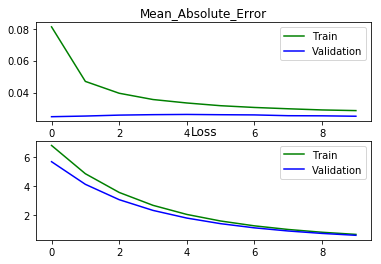

In [17]:
plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")


plt.subplot(211)
plt.title("Mean_Absolute_Error")
plt.plot(history.history["mean_absolute_error"], color="g", label="Train")
plt.plot(history.history["val_mean_absolute_error"], color="b", label="Validation")
plt.legend(loc="best")

#plt.tight_layout()
plt.show()

In [ ]:
plt.subplot(212)
plt.title("Loss")
plt.plot(history1.history1["loss"], color="g", label="Train")
plt.plot(history1.history1["val_loss"], color="b", label="Validation")
plt.legend(loc="best")


plt.subplot(211)
plt.title("Mean_Absolute_Error")
plt.plot(history1.history1["mean_absolute_error"], color="g", label="Train")
plt.plot(history1.history1["val_mean_absolute_error"], color="b", label="Validation")
plt.legend(loc="best")

#plt.tight_layout()
plt.show()